<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/tim-lr-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df_train.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1


In [41]:
df_test.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
356588,She was born with the name Maria SkÅ odowska i...,she be bear with the name maria sk odowska in ...,7.174366,4.007143,3.57,5.11,2.86,1.43,4.88,12.0,0
304697,The highest wind gust reported in Guadeloupe w...,the high wind gust report in guadeloupe be 84 ...,6.333686,5.620000,3.69,8.66,2.94,1.43,3.93,14.0,0


In [42]:
df_train = df_train[df_train.num_lemmas > 1]
df_train.label.value_counts()

1    186406
0    179003
Name: label, dtype: int64

In [43]:
num_features = ['d_chall_score', 'aoa_max', 'num_lemmas']

text_features = 'lemmatized_text'

def build_clf(tfidf_args={}, clf_kwargs={}):
  num_pipe = Pipeline([
      ('impute', SimpleImputer(strategy='mean')),
      # I'm going to try binning to speed convergence while using
      # heterogeneous features (dense numeric values and sparse tfidf vectors)
      ('binner', KBinsDiscretizer(n_bins=4)),
  ])

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_args)),
  ])

  preprocessor = ColumnTransformer([
      ('num', num_pipe, num_features),
      ('text', text_pipe, text_features),
  ])

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', LogisticRegression(**clf_kwargs))
  ])

  return clf
  
clf = build_clf()

Lets use a sample for hyper-parameter tuning so that we're not here all day.

In [44]:
sample_df = df_train.groupby('label').apply(lambda grp: grp.sample(20000, random_state=99))

Lets do a grid search to find optimal hyper-parameters

In [51]:
# When using a pipeline in grid search, you can prepend the parameter
# you want to tune with the pipeline component name (clf) and two underscores (__).
tfidf_prefix = 'preprocessor__text__tfidf__'
clf_prefix = 'clf__'

param_grid = {tfidf_prefix + 'min_df':[50],
              tfidf_prefix + 'ngram_range':[(1, 3)],
              tfidf_prefix + 'stop_words':[None],
              clf_prefix + 'C':[.6, .7], 
              clf_prefix + 'penalty':['l1'],
              clf_prefix + 'solver':['saga'],
              clf_prefix + 'random_state':[99],
              clf_prefix + 'n_jobs':[-1],}

grid = (GridSearchCV(clf, 
                    param_grid=param_grid,
                    scoring='accuracy', 
                    cv=StratifiedKFold(n_splits=10),
                    refit=False,
                    verbose=1,
                    return_train_score=True,
                    # n_jobs=-1 interfers with the verbosity (output) of the
                    # grid search. We'll have to look at the results after the
                    # fact.
                    error_score='raise',
                    n_jobs=-1)
        .fit(sample_df, sample_df['label']))

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [52]:
print(grid.best_params_)

pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').T

{'clf__C': 0.6, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 99, 'clf__solver': 'saga', 'preprocessor__text__tfidf__min_df': 50, 'preprocessor__text__tfidf__ngram_range': (1, 3), 'preprocessor__text__tfidf__stop_words': None}


,0,1
mean_fit_time,31.371294,33.524717
std_fit_time,3.027775,3.653475
mean_score_time,0.286947,0.272014
std_score_time,0.019572,0.029496
param_clf__C,0.6,0.7
param_clf__n_jobs,-1,-1
param_clf__penalty,l1,l1
param_clf__random_state,99,99
param_clf__solver,saga,saga
param_preprocessor__text__tfidf__min_df,50,50


Build a new model using best params

In [54]:
tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid.best_params_.items() 
                     if tfidf_prefix in k}

clf_best_params = {k[len(clf_prefix):]:v 
                   for (k, v) in grid.best_params_.items() 
                   if clf_prefix in k}
clf_best_params['max_iter'] = 1000

clf = build_clf(tfidf_best_params, clf_best_params)

Final test on our training data to see if our model is overfitting.

In [55]:
X_train, X_val, y_train, y_val = train_test_split(df_train[num_features + [text_features]], 
                                                  df_train['label'],
                                                  test_size=.25,
                                                  stratify=df_train['label'], 
                                                  random_state=99)

clf = clf.fit(X_train, y_train)

train_y_proba = clf.predict_proba(X_train)[:, 1]
train_y_hat = clf.predict(X_train)

val_y_proba = clf.predict_proba(X_val)[:, 1]
val_y_hat = clf.predict(X_val)

train_roc_auc = metrics.roc_auc_score(y_train, train_y_proba)
train_accuracy = metrics.accuracy_score(y_train, train_y_hat)
train_f1 = metrics.f1_score(y_train, train_y_hat)
train_precision = metrics.precision_score(y_train, train_y_hat)
train_recall = metrics.recall_score(y_train, train_y_hat)

val_roc_auc = metrics.roc_auc_score(y_val, val_y_proba)
val_accuracy = metrics.accuracy_score(y_val, val_y_hat)
val_f1 = metrics.f1_score(y_val, val_y_hat)
val_precision = metrics.precision_score(y_val, val_y_hat)
val_recall = metrics.recall_score(y_val, val_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Validation ROC AUC:', val_roc_auc)
print('Validation Accuracy Score:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Precision Score:', val_precision)
print('Validation Recall Score:', val_recall)


Train ROC AUC: 0.801435410732124
Train Accuracy Score: 0.7244541261639956
Train F1 Score: 0.733525063076733
Train Precision Score: 0.7238771146600177
Train Recall Score: 0.7434336642728391

Validation ROC AUC: 0.7791702644010235
Validation Accuracy Score: 0.706304116996705
Validation F1 Score: 0.7162528025720208
Validation Precision Score: 0.7061558994035951
Validation Recall Score: 0.726642633363375


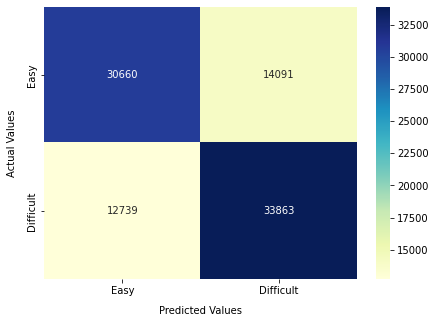

In [56]:
def plot_cf_matrix(y_true, y_pred):
  cf_matrix = metrics.confusion_matrix(y_true, y_pred).round(0)
  tick_lables = ('Easy', 'Difficult')

  fig = plt.figure(figsize=(7, 5))
  ax = plt.gca()
  ax = sns.heatmap(cf_matrix, 
              annot=True,
              fmt='.0f',
              xticklabels=tick_lables,
              yticklabels=tick_lables,
              cmap=mpl.cm.get_cmap('YlGnBu'),
              ax=ax,)
  
  ax.set_xlabel('Predicted Values', labelpad=10.0)
  ax.set_ylabel('Actual Values', labelpad=10.0)

plot_cf_matrix(y_val, val_y_hat)

Lets look at the most important features

In [57]:
# Get transformed feature names.
num_features_trf = (clf['preprocessor']
                    .transformers_[0][1]
                    ['binner']
                    .get_feature_names_out(num_features))

text_features_trf = (clf['preprocessor']
                 .transformers_[1][1]
                 ['tfidf']
                 .get_feature_names_out())

all_features_trf = list(num_features_trf) + list(text_features_trf)

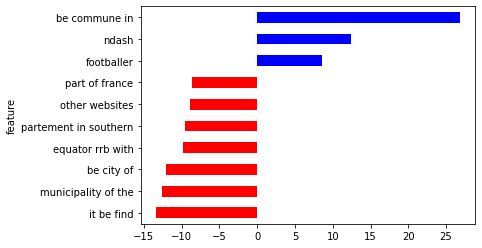

In [58]:
df_coef = pd.DataFrame({'feature':all_features_trf, 
                        'coef':clf['clf'].coef_[0],
                        'abscoef':np.abs(clf['clf'].coef_[0]),
                        'is_positive':clf['clf'].coef_[0] >= 0})
# What are top 10 most important features
def plot_top_10(df_plot):
  df_plot = (df_plot
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}), 
                    legend=None)

plot_top_10(df_coef)

What are the most import readability features.

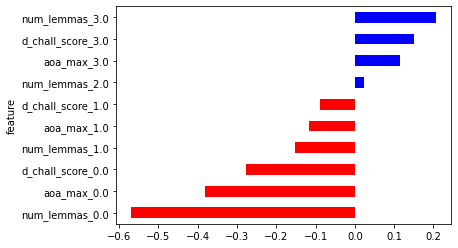

In [59]:
def plot_top_10_readability(df_plot):
  df_plot = (df_plot[df_plot.feature.isin(num_features_trf)]
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}),
                    legend=None)
  
plot_top_10_readability(df_coef)

## Final test

In [ ]:
clf = clf.fit(df_train, df_train['label'])

train_y_proba = clf.predict_proba(df_train)[:, 1]
train_y_hat = clf.predict(df_train)

test_y_proba = clf.predict_proba(df_test)[:, 1]
test_y_hat = clf.predict(df_test)

train_roc_auc = metrics.roc_auc_score(df_train['label'], train_y_proba)
train_accuracy = metrics.accuracy_score(df_train['label'], train_y_hat)
train_f1 = metrics.f1_score(df_train['label'], train_y_hat)
train_precision = metrics.precision_score(df_train['label'], train_y_hat)
train_recall = metrics.recall_score(df_train['label'], train_y_hat)

test_roc_auc = metrics.roc_auc_score(df_test['label'], test_y_proba)
test_accuracy = metrics.accuracy_score(df_test['label'], test_y_hat)
test_f1 = metrics.f1_score(df_test['label'], test_y_hat)
test_precision = metrics.precision_score(df_test['label'], test_y_hat)
test_recall = metrics.recall_score(df_test['label'], test_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Test ROC AUC:', test_roc_auc)
print('Test Accuracy Score:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test Precision Score:', test_precision)
print('Test Recall Score:', test_recall)


Train ROC AUC: 0.8095097603189146
Train Accuracy Score: 0.7318364561227646
Train F1 Score: 0.7345329399158621
Train Precision Score: 0.7272204686552812
Train Recall Score: 0.7419939641474624

Test ROC AUC: 0.7909177195445566
Test Accuracy Score: 0.7161195892120165
Test F1 Score: 0.7176978691927748
Test Precision Score: 0.7137297707749988
Test Recall Score: 0.7217103368845379


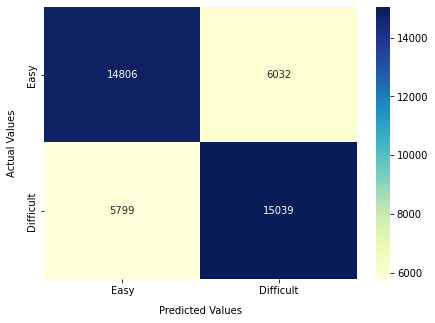

In [ ]:
plot_cf_matrix(df_test['label'], test_y_hat)

Lets save our final model

In [ ]:
model_path = ''.join([repo_path, 'logistic-regression-clf.joblib'])
joblib.dump(clf, model_path)

['/content/drive/MyDrive/milestone-ii/logistic-regression-clf.joblib']